In [26]:
# import the modules
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")



### Load the dataset

- Load the train data and using all your knowledge try to explore the different statistical properties of the dataset.

In [27]:
# Code starts here
train = pd.read_csv('train.csv')
print(train.head(5))
print(train.shape)
print(train.info())
print(train.describe())

test = pd.read_csv('test.csv')
print(test.shape)
print(test.info())


# Code ends here

   Unnamed: 0         ID  KIDSDRIV   AGE  HOMEKIDS   YOJ   INCOME PARENT1  \
0        3678  531817639         1  42.0         3   9.0   $4,701      No   
1        2533  738075150         0  50.0         0   7.0  $10,232      No   
2        9169  176935775         0  40.0         2  17.0  $66,200     Yes   
3        4174  195054268         2  38.0         2  13.0  $34,056      No   
4       10150  764551255         0  38.0         0   NaN  $45,734      No   

   HOME_VAL MSTATUS  ... TIF    CAR_TYPE RED_CAR  OLDCLAIM CLM_FREQ REVOKED  \
0        $0     Yes  ...   1  Sports Car      no        $0        0      No   
1  $129,979     Yes  ...  16     Minivan      no    $5,458        2      No   
2  $223,960    z_No  ...  13       z_SUV      no        $0        0      No   
3  $122,908     Yes  ...   4  Sports Car      no      $502        1      No   
4  $222,653     Yes  ...   1      Pickup      no    $3,296        1      No   

   MVR_PTS CLM_AMT CAR_AGE CLAIM_FLAG  
0        4      $0    

In [28]:
def imputer_for_null_values(train_data,test_data,column,imputer_type):
    mean_imputer = SimpleImputer(strategy='mean')
    mode_imputer = SimpleImputer(strategy='most_frequent')
    for n in range(0,len(column)):
        if(imputer_type == 'mean'):        
            mean_imputer.fit(train_data[[column[n]]])
            train_data[column[n]] = mean_imputer.transform(train_data[[column[n]]])
            test_data[column[n]] = mean_imputer.transform(test_data[[column[n]]])
        elif(imputer_type == 'mode'):
            mode_imputer.fit(train[[column[n]]])
            train_data[column[n]]=mode_imputer.transform(train_data[[column[n]]])
            test_data[column[n]]=mode_imputer.transform(test_data[[column[n]]])
    return train_data,test_data
        
        

In [29]:
def remove_unwanted_char(data,column,char):
    for n in range(0,len(column)):
        for i in range(0,len(char)):
            data[column[n]] = data[column[n]].str.replace(char[i],'')
    return data



In [30]:
def change_dtype(data,column,to_type):
    for n in range(0,len(column)):
        data = data.astype({column[n]: to_type})
    return data

### Visualize the data

- Check for the categorical & continuous features. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Clean the data, apply some data preprocessing and engineering techniques.

In [31]:
columns = ['INCOME','HOME_VAL','OLDCLAIM','CLM_AMT','BLUEBOOK']
signs = ['$',',']

train = remove_unwanted_char(train,columns,signs)
test = remove_unwanted_char(test,columns,signs)
#print(train.head(5))

In [32]:
columns_mean = ['AGE','YOJ','INCOME','HOME_VAL','CAR_AGE']
train,test = imputer_for_null_values(train,test,columns_mean,'mean')
columns_mode = ['OCCUPATION']
train,test = imputer_for_null_values(train,test,columns_mode,'mode')
print(train.isnull().sum().values.sum())
print(test.isnull().sum().values.sum())

0
0


In [33]:
train = change_dtype(train,columns,float)
test = change_dtype(test,columns,float)
print(train.dtypes)

Unnamed: 0      int64
ID              int64
KIDSDRIV        int64
AGE           float64
HOMEKIDS        int64
YOJ           float64
INCOME        float64
PARENT1        object
HOME_VAL      float64
MSTATUS        object
GENDER         object
EDUCATION      object
OCCUPATION     object
TRAVTIME        int64
CAR_USE        object
BLUEBOOK      float64
TIF             int64
CAR_TYPE       object
RED_CAR        object
OLDCLAIM      float64
CLM_FREQ        int64
REVOKED        object
MVR_PTS         int64
CLM_AMT       float64
CAR_AGE       float64
CLAIM_FLAG      int64
dtype: object


In [34]:
# choose categorical and continuous features from data

categorical_columns = [c for c in train.columns 
                       if train[c].dtype.name == 'object']
numerical_columns = [c for c in train.columns 
                     if train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED']
numerical_columns: ['Unnamed: 0', 'ID', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE', 'CLAIM_FLAG']


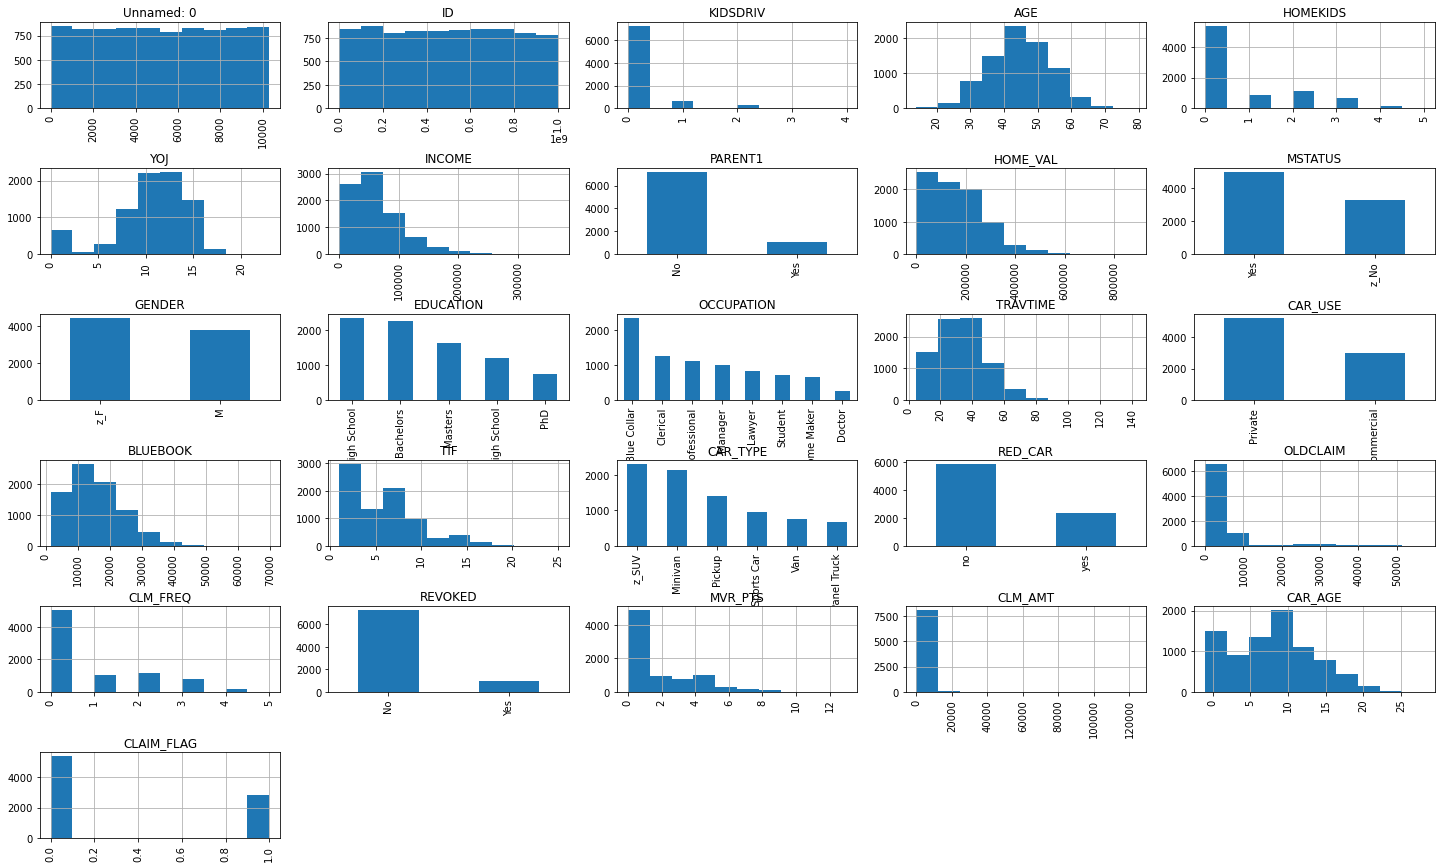

In [35]:
# Code starts here


fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(train.shape[1]) / cols)
for i, column in enumerate(train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if train.dtypes[column] == np.object:
        train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Code ends here.

In [36]:
le = LabelEncoder()

for x in categorical_columns:
    train[x] = le.fit_transform(train[x].astype(str))
    if x in [c for c in test.columns 
                       if test[c].dtype.name == 'object']:
        test[x] = le.transform(test[x].astype(str))

### Model building

- Separate the features and target.
- Now let's come to the actual task, using Decision Tree, predict the `paid.back.loan`. Use different techniques you have learned to imporove the performance of the model.
- Try improving upon the `accuracy_score` ([Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

In [37]:
# Code Starts here
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

# Code ends here

In [38]:
# Code Starts here
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

tree_predictions = tree.predict(X_val) 
print("Decision tree f1 score: ",f1_score(y_val,tree_predictions))


# Code ends here

Decision tree f1 score:  0.7270358306188924


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [39]:
# Code Starts here

# Storing the id from the test file
id_ = test['ID']

# Predict on the test data
y_pred_test = tree.predict(test)

# Create a sample submission file
final_submission = pd.DataFrame({'':id_,'CLAIM_FLAG':y_pred_test})


# Convert the sample submission file into a csv file
final_submission.to_csv('final_submission.csv',index=False)

# Code ends here